<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/Chest%20X_Ray/Comparison_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# ============================================
# COMPLETE CHEST X-RAY CLASSIFICATION PIPELINE
# MobileNetV2 - Train, Evaluate, Save Results
# ============================================

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ----------------------------
# 0. Hyperparameters / Summary
# ----------------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
FINE_TUNE_LAYERS = 20
ROTATION_RANGE = 15
ZOOM_RANGE = 0.1
WIDTH_SHIFT_RANGE = 0.1
HEIGHT_SHIFT_RANGE = 0.1
HORIZONTAL_FLIP = True
MAX_IMAGES_PER_CLASS = 500
TRAIN_TEST_SPLIT = 0.8


In [ ]:
# ----------------------------
# 1. Mount Google Drive
# ----------------------------
from google.colab import drive
drive.mount('/content/drive')

# ----------------------------
# 2. Dataset Split
# ----------------------------
dataset_dir = '/content/drive/MyDrive/Chest X_Ray'
output_dir = '/content/Chest_XRay_split'
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

for folder in [train_dir, test_dir]:
    for cls in ['NORMAL', 'PNEUMONIA']:
        os.makedirs(os.path.join(folder, cls), exist_ok=True)

for cls in ['NORMAL', 'PNEUMONIA']:
    cls_dir = os.path.join(dataset_dir, cls)
    images = [img for img in os.listdir(cls_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))][:MAX_IMAGES_PER_CLASS]
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
    for img in train_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(test_dir, cls, img))

print("Dataset split completed successfully!")

In [5]:
# ----------------------------
# 3. Image Generators
# ----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=ROTATION_RANGE,
    zoom_range=ZOOM_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    horizontal_flip=HORIZONTAL_FLIP
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [6]:
# ----------------------------
# 4. Model Builder
# ----------------------------
def build_model(fine_tune_layers=FINE_TUNE_LAYERS):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
    for layer in base_model.layers[:-fine_tune_layers]:
        layer.trainable = False
    for layer in base_model.layers[-fine_tune_layers:]:
        layer.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [7]:
# ----------------------------
# 5. Train Model
# ----------------------------
def train_model(model, model_name='MobileNetV2', epochs=EPOCHS):
    checkpoint = ModelCheckpoint(f'{model_name}.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=epochs,
        callbacks=[checkpoint, early_stop]
    )
    return history


In [ ]:
# ----------------------------
# 6. Compute Metrics
# ----------------------------
def compute_medical_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall (Sensitivity)": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "Specificity": tn / (tn + fp)
    }

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8697 - loss: 0.3613
Epoch 1: val_accuracy improved from -inf to 0.53500, saving model to MobileNetV2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8705 - loss: 0.3600 - val_accuracy: 0.5350 - val_loss: 4.1827
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9349 - loss: 0.1625
Epoch 2: val_accuracy did not improve from 0.53500
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 892ms/step - accuracy: 0.9352 - loss: 0.1622 - val_accuracy: 0.5000 - val_loss: 9.2750
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.9640 - loss: 0.0930
Epoch 3: val_accuracy improved from 0.53500 to 0.58500, saving model to MobileNetV2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 841ms/step - accuracy: 0.9640 - loss: 0.0931 - val_accuracy: 0.5850 - val_loss: 4.9939
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.9553 - loss: 0.1144
Epoch 4: val_accuracy improved from 0.58500 to 0.69500, saving model to MobileNetV2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 889ms/step - accuracy: 0.9552 - loss: 0.1146 - val_accuracy: 0.6950 - val_loss: 3.4323
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.9701 - loss: 0.0762
Epoch 5: val_accuracy improved from 0.69500 to 0.96000, saving model to MobileNetV2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 839ms/step - accuracy: 0.9697 - loss: 0.0772 - val_accuracy: 0.9600 - val_loss: 0.4427
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9716 - loss: 0.0744
Epoch 6: val_accuracy did not improve from 0.96000
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 902ms/step - accuracy: 0.9715 - loss: 0.0747 - val_accuracy: 0.7950 - val_loss: 1.7868
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.9627 - loss: 0.0677
Epoch 7: val_accuracy did not improve from 0.96000
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 943ms/step - accuracy: 0.9630 - loss: 0.0676 - val_accuracy: 0.7800 - val_loss: 2.5357
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9754 - loss: 0.0756
Epoch 8: val_accuracy did not improve from 0.96000
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 806ms/step - accuracy: 0.9751 - loss: 0.0768 - val_accuracy: 0.9050 - val_loss: 1.1118
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9664 - loss: 0.0996
Epoch 9: val_accuracy did not impr

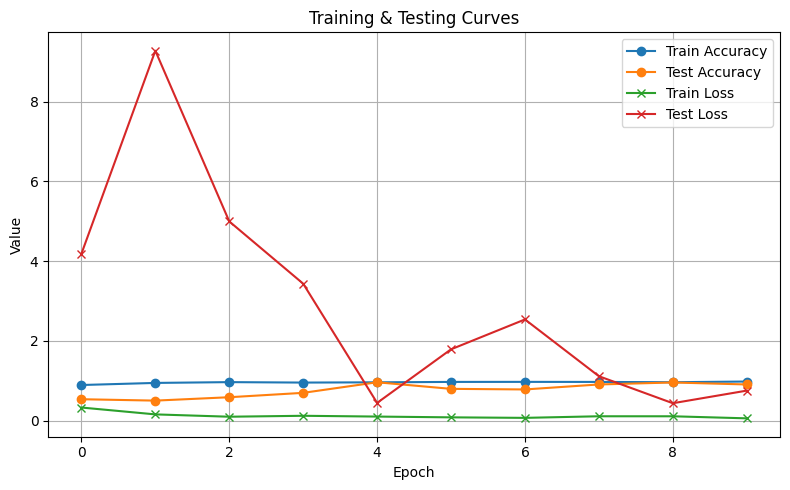


Performance Metrics Table:


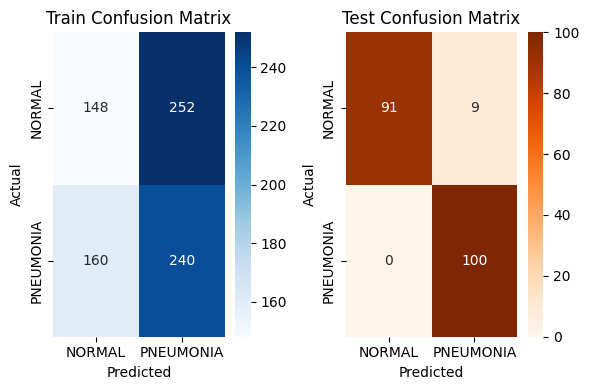


All results saved in folder: results_MobileNetV2


In [8]:
# ----------------------------
# 7. Evaluate Model
# ----------------------------
def evaluate_model(model, history, train_gen, test_gen, model_name='MobileNetV2'):
    results_dir = f"results_{model_name}"
    os.makedirs(results_dir, exist_ok=True)

    # ---- Train/Test Accuracy & Loss Curves ----
    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy', marker='o')
    plt.plot(history.history['loss'], label='Train Loss', marker='x')
    plt.plot(history.history['val_loss'], label='Test Loss', marker='x')
    plt.xlabel('Epoch'); plt.ylabel('Value'); plt.title('Training & Testing Curves'); plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig(f"{results_dir}/train_test_curves.png", dpi=300)
    plt.show()

    # ---- Compute Metrics and Save Table ----
    metrics_table = []
    for name, gen in zip(['Train', 'Test'], [train_gen, test_gen]):
        gen.reset()
        y_true = gen.classes
        y_pred_prob = model.predict(gen, verbose=0)
        y_pred = np.argmax(y_pred_prob, axis=1)
        metrics = compute_medical_metrics(y_true, y_pred)
        metrics["Dataset"] = name
        metrics["Model"] = model_name
        metrics_table.append(metrics)
    df_metrics = pd.DataFrame(metrics_table)
    df_metrics.to_csv(f"{results_dir}/performance_metrics.csv", index=False)
    print("\nPerformance Metrics Table:")
    df_metrics

    # ---- Train & Test Confusion Matrices Side by Side ----
    train_gen.reset(); test_gen.reset()
    y_true_train = train_gen.classes
    y_pred_train = model.predict(train_gen, verbose=0).argmax(axis=1)
    y_true_test = test_gen.classes
    y_pred_test = model.predict(test_gen, verbose=0).argmax(axis=1)
    cm_train = confusion_matrix(y_true_train, y_pred_train)
    cm_test = confusion_matrix(y_true_test, y_pred_test)

    plt.figure(figsize=(6,4))
    plt.subplot(1,2,1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
    plt.title('Train Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.subplot(1,2,2)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.title('Test Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f"{results_dir}/train_test_confusion_matrix.png", dpi=300)
    plt.show()

    print(f"\nAll results saved in folder: {results_dir}")

# ----------------------------
# 8. Train & Evaluate MobileNetV2
# ----------------------------
mobilenet_model = build_model()
mobilenet_history = train_model(mobilenet_model, 'MobileNetV2', epochs=EPOCHS)
evaluate_model(mobilenet_model, mobilenet_history, train_generator, test_generator, model_name='MobileNetV2')


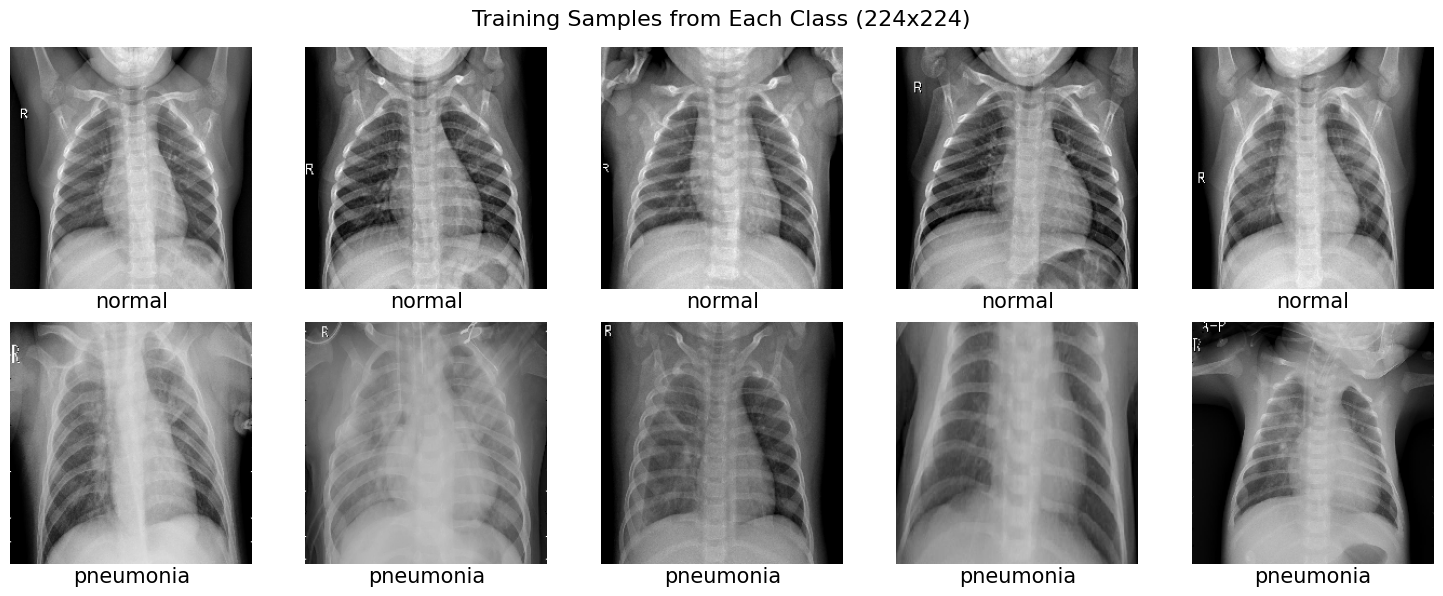

In [24]:
# ============================================
# Display 5 Sample Images per Class from Training Data
# ============================================

import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

classes = ['NORMAL', 'PNEUMONIA']
samples_per_class = 5
IMG_SIZE = (224, 224)

plt.figure(figsize=(15, 6))

for i, cls in enumerate(classes):
    cls_dir = os.path.join(train_dir, cls)
    images = [img for img in os.listdir(cls_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_imgs = random.sample(images, samples_per_class)

    for j, img_name in enumerate(selected_imgs):
        img_path = os.path.join(cls_dir, img_name)
        img = load_img(img_path, target_size=IMG_SIZE)   # resize to 224x224
        img_array = img_to_array(img) / 255.0            # normalize for visualization

        plt.subplot(len(classes), samples_per_class, i*samples_per_class + j + 1)
        plt.imshow(img_array.astype('float32'))
        plt.axis('off')
        # Move text below the image by increasing y-coordinate
        plt.text(112, 240, cls.lower(), fontsize=15, ha='center')

plt.suptitle("Training Samples from Each Class (224x224)", fontsize=16)
plt.subplots_adjust(hspace=0.4)  # space between rows
plt.tight_layout()
plt.savefig(f"samples.png", dpi=300)
plt.show()
